# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## >> Objective of Starbucks Capstone Project 

### What type of offers should starbucks create ?
### and which customers should they distribute to ?
### to make most amount of money $$



In short understanding demand and customer base

# 1. Data Exploration & Visualisation 

In [1]:
import pandas as pd
import numpy as np
import math
import json
import sys
import datetime
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio

In [2]:
#Having a glance at all the portfolio data. Small and easy !
#import sns
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**portfolio**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
#Glancing at the data types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


## Profile

In [4]:
#Profile dataset is compact. Lets see how is income distributed
#profile.head(5)
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


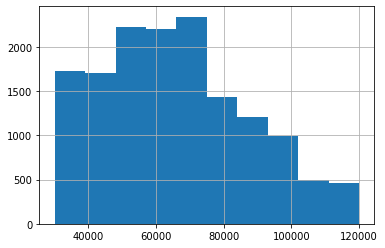

In [5]:
# Income is right skewed
profile['income'].hist();

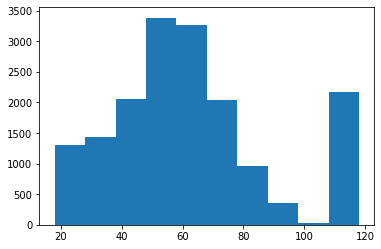

In [6]:
#Age is slightly right skewed and some outliers towards the right corner
plt.hist(profile['age'], bins=10);

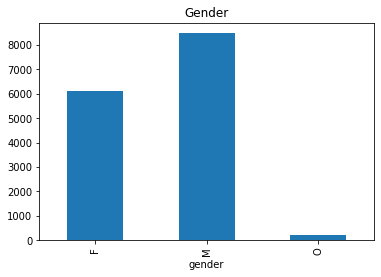

In [7]:
#Gender with Income Range
count_vals = profile.groupby('gender').size()

(count_vals[:10]).plot(kind="bar");
plt.title("Gender");

In [8]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**profile**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [9]:
#Seems like gender and income have some null values
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


## Transcript

In [10]:
#Transcript dataset has all transactions to and by a customer
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [11]:
#Good that no value here is null
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**transcript**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [12]:
#Understanding how often each event occurs in transcript
transcript.groupby('event').size()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
dtype: int64

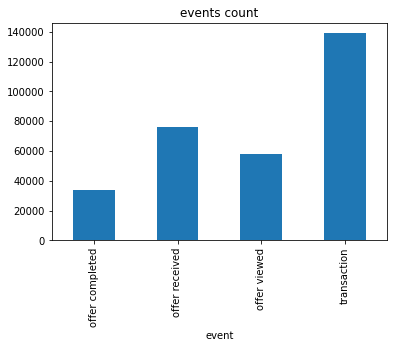

In [13]:
#event
count_vals = transcript.groupby('event').size()

(count_vals[:10]).plot(kind="bar");
plt.title("events count");

# Methodology

## Data Processing

### Profile data processing

In [14]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
#renaming id to person
profile = profile.rename(columns={'id':'person'})

#checking if person column has duplicate values
boolean = not profile["person"].is_unique
boolean = profile['person'].duplicated().any()
boolean

False

In [16]:
#changing type of columns
profile['age'] = profile['age'].astype(int)

In [17]:
profile = profile.reindex(columns=['person', 'age', 'gender', 'became_member_on', 'income'])

In [18]:
profile.head(2)

,person,age,gender,became_member_on,income
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,20170212,NaN
1,0610b486422d4921ae7d2bf64640c50b,55,F,20170715,112000.0


In [19]:
#Removing age 118 as it looks like some system error. I will be happy to live at that age though :=)
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [20]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            17000 non-null  object 
 1   age               14825 non-null  float64
 2   gender            14825 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 664.2+ KB


In [21]:
profile[['age','income']] = profile[['age','income']].astype('int', errors='ignore')

In [22]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['member_since_year'] = profile['became_member_on'].dt.year
profile['member_since_month'] = profile['became_member_on'].dt.month
profile['member_duration'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date
profile['member_duration'] = profile['member_duration'].dt.days

In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   person              17000 non-null  object        
 1   age                 14825 non-null  float64       
 2   gender              14825 non-null  object        
 3   became_member_on    17000 non-null  datetime64[ns]
 4   income              14825 non-null  float64       
 5   member_since_year   17000 non-null  int64         
 6   member_since_month  17000 non-null  int64         
 7   member_duration     17000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.0+ MB


In [24]:
profile.head(5)

,person,age,gender,became_member_on,income,member_since_year,member_since_month,member_duration
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,None,2017-02-12,NaN,2017,2,1801
1,0610b486422d4921ae7d2bf64640c50b,55.0,F,2017-07-15,112000.0,2017,7,1648
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,None,2018-07-12,NaN,2018,7,1286
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,F,2017-05-09,100000.0,2017,5,1715
4,a03223e636434f42ac4c3df47e8bac43,NaN,None,2017-08-04,NaN,2017,8,1628


## 2b. Portfolio dataframe processing

In [25]:
#Changing id to offer_id
portfolio = portfolio.rename(columns={'id':'offer_id'})

#Extracting channels into other columns as 0's and 1's
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [26]:
portfolio = portfolio.drop('channels', axis=1)
portfolio

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## 2c. transcript dataframe processing

In [27]:
# First we need to check what values are there in the value column
values = []
for idx, row in transcript.iterrows():
    for v in row['value']:
        if v in values:
            continue
        else:
            values.append(v)

In [28]:
values

['offer id', 'amount', 'offer_id', 'reward']

We are only interested in 'offer id' and 'amount' as reward would come anyways from portfolio table after joining

In [29]:
#create new columns with datatypes
transcript['offer_id'] = '' # str
transcript['amount'] = 0  # int
##transcript['reward'] = 0  # int

In [30]:
for idx, row in transcript.iterrows():
    for v in row['value']:
        if v == 'offer_id' or v == 'offer id':
            transcript.at[idx, 'offer_id'] = row['value'][v]
        if v == 'amount':
            transcript.at[idx, 'amount'] = row['value'][v]
##        if v == 'reward':
##            transcript.at[idx, 'reward'] = row['value'][v]

In [31]:
# filling all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable)
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [32]:
# dropping the 'value' column 
transcript.drop('value', axis=1, inplace=True)

In [33]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [34]:
#vWhere offer_id is N/A is actually a transaction type event
transcript.groupby(['offer_id','event']).size()

offer_id                          event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer completed      3420
                                  offer received       7668
                                  offer viewed         2663
2298d6c36e964ae4a3e7e9706d1fb8c2  offer completed      5156
                                  offer received       7646
                                  offer viewed         7337
2906b810c7d4411798c6938adc9daaa5  offer completed      4017
                                  offer received       7632
                                  offer viewed         4118
3f207df678b143eea3cee63160fa8bed  offer received       7617
                                  offer viewed         4144
4d5c57ea9a6940dd891ad53e9dbe8da0  offer completed      3331
                                  offer received       7593
                                  offer viewed         7298
5a8bc65990b245e5a138643cd4eb9837  offer received       7618
                                  offer viewed    

In [35]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   person    306534 non-null  object
 1   event     306534 non-null  object
 2   time      306534 non-null  int64 
 3   offer_id  306534 non-null  object
 4   amount    306534 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.7+ MB


In [36]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [37]:
#transcript['time_h'] = transcript['time']/24
#transcript = transcript.drop('time', axis=1)

## 2d - Joining Transcript to Profile and then to Portfolio

In [38]:
df_all = transcript.merge(profile, on='person', how='left')

In [39]:
df_all = df_all.merge(portfolio, on='offer_id', how='left')

In [40]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   person              306534 non-null  object        
 1   event               306534 non-null  object        
 2   time                306534 non-null  int64         
 3   offer_id            306534 non-null  object        
 4   amount              306534 non-null  int64         
 5   age                 272762 non-null  float64       
 6   gender              272762 non-null  object        
 7   became_member_on    306534 non-null  datetime64[ns]
 8   income              272762 non-null  float64       
 9   member_since_year   306534 non-null  int64         
 10  member_since_month  306534 non-null  int64         
 11  member_duration     306534 non-null  int64         
 12  reward              167581 non-null  float64       
 13  difficulty          167581 no

In [41]:
#Changing Float to Int datatypes of some columns where it makes sense
df_all[['time','income','age','reward','difficulty',
        'duration','channel_email',
        'channel_mobile','channel_social',
        'channel_web']] = df_all[['time','income','age','reward',
                                  'difficulty','duration','channel_email','channel_mobile',
                                  'channel_social','channel_web']].astype('Int64')

In [42]:
#This is the final single table that will be used for all our analysis
df_all.head(5)

,person,event,time,offer_id,amount,age,gender,became_member_on,income,member_since_year,member_since_month,member_duration,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,75,F,2017-05-09,100000,2017,5,1715,5,5,7,bogo,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,<NA>,None,2017-08-04,<NA>,2017,8,1628,5,20,10,discount,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,68,M,2018-04-26,70000,2018,4,1363,2,10,7,discount,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,<NA>,None,2017-09-25,<NA>,2017,9,1576,2,10,10,discount,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,<NA>,None,2017-10-02,<NA>,2017,10,1569,10,10,5,bogo,1,1,1,1


In [43]:
df_all['age_group'] = pd.cut(df_all['age'], bins=[17, 35, 55, 103],
                labels=['young-adulthood', 'middle-age', 'older-adulthood'])

In [44]:
df_all['income_group'] = pd.cut(df_all['income'], bins=[0, 49000, 80000, 120000],
                labels=['low', 'mid', 'high'])

In [45]:
df_all.head(5)

,person,event,time,offer_id,amount,age,gender,became_member_on,income,member_since_year,...,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,age_group,income_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,75,F,2017-05-09,100000,2017,...,5,5,7,bogo,1,1,0,1,older-adulthood,high
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,<NA>,None,2017-08-04,<NA>,2017,...,5,20,10,discount,1,0,0,1,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,68,M,2018-04-26,70000,2018,...,2,10,7,discount,1,1,0,1,older-adulthood,mid
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,<NA>,None,2017-09-25,<NA>,2017,...,2,10,10,discount,1,1,1,1,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,<NA>,None,2017-10-02,<NA>,2017,...,10,10,5,bogo,1,1,1,1,NaN,NaN


In [46]:
df_all = df_all.reindex(columns=['person', 'event', 'offer_id', 'difficulty', 'duration',
                        'offer_type','reward','channel_email','channel_mobile','channel_social',
                        'channel_web','time','amount','age','age_group','became_member_on',
                        'gender','income','income_group','member_since_year','member_since_month','member_duration'])

In [47]:
df_all.head(5)

,person,event,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,...,amount,age,age_group,became_member_on,gender,income,income_group,member_since_year,member_since_month,member_duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,...,0,75,older-adulthood,2017-05-09,F,100000,high,2017,5,1715
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,...,0,<NA>,NaN,2017-08-04,None,<NA>,NaN,2017,8,1628
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,...,0,68,older-adulthood,2018-04-26,M,70000,mid,2018,4,1363
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,...,0,<NA>,NaN,2017-09-25,None,<NA>,NaN,2017,9,1576
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,...,0,<NA>,NaN,2017-10-02,None,<NA>,NaN,2017,10,1569


In [48]:
df_all['offer_id'].value_counts()

N/A                                 138953
fafdcd668e3743c1bb461111dcafc2a4     20241
2298d6c36e964ae4a3e7e9706d1fb8c2     20139
f19421c1d4aa40978ebb69ca19b0e20d     19131
4d5c57ea9a6940dd891ad53e9dbe8da0     18222
ae264e3637204a6fb9bb56bc8210ddfd     18062
9b98b8c7a33c4b65b9aebfe6a799e6d9     16202
2906b810c7d4411798c6938adc9daaa5     15767
5a8bc65990b245e5a138643cd4eb9837     14305
0b1e1539f2cc45b7b9fa7c272da2e1d7     13751
3f207df678b143eea3cee63160fa8bed     11761
Name: offer_id, dtype: int64

In [49]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   person              306534 non-null  object        
 1   event               306534 non-null  object        
 2   offer_id            306534 non-null  object        
 3   difficulty          167581 non-null  Int64         
 4   duration            167581 non-null  Int64         
 5   offer_type          167581 non-null  object        
 6   reward              167581 non-null  Int64         
 7   channel_email       167581 non-null  Int64         
 8   channel_mobile      167581 non-null  Int64         
 9   channel_social      167581 non-null  Int64         
 10  channel_web         167581 non-null  Int64         
 11  time                306534 non-null  Int64         
 12  amount              306534 non-null  int64         
 13  age                 272762 no

# Implementation

### Descriptive Analytics

Which age group views most offers ?

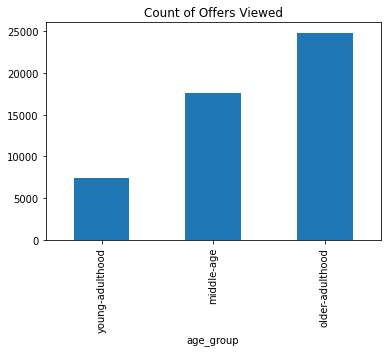

In [50]:
count_vals = df_all[df_all['event'] == 'offer viewed'].groupby('age_group').size()

(count_vals[:10]).plot(kind="bar");
plt.title("Count of Offers Viewed");

Women have overall a higher income than men

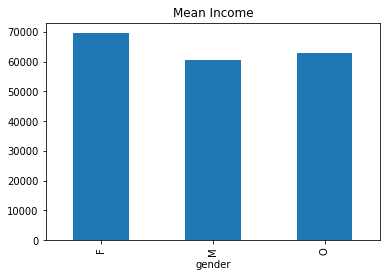

In [51]:
#Gender with Income Range
count_vals = df_all.groupby('gender')['income'].mean()

(count_vals[:10]).plot(kind="bar");
plt.title("Mean Income");

What Offer to send to which customer ?

In [52]:
# First taking a subset of combined data
df_all[['offer_id','event','age_group','income_group','gender','channel_email','channel_mobile','channel_social','channel_web']].head(5)

,offer_id,event,age_group,income_group,gender,channel_email,channel_mobile,channel_social,channel_web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,older-adulthood,high,F,1,1,0,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,None,1,0,0,1
2,2906b810c7d4411798c6938adc9daaa5,offer received,older-adulthood,mid,M,1,1,0,1
3,fafdcd668e3743c1bb461111dcafc2a4,offer received,NaN,NaN,None,1,1,1,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,NaN,NaN,None,1,1,1,1


In [53]:
# To the core it seems since values are simulated its hard to form patterns anywhere 
# So probably using machine learning algorithms doesn't make sense as there is no bias

df_all[df_all['event'] == 'offer viewed'].groupby(['gender','offer_id']).sum()[['channel_email','channel_mobile','channel_social','channel_web']]

channel_email  channel_mobile  \
gender offer_id                                                          
F      0b1e1539f2cc45b7b9fa7c272da2e1d7            982               0   
       2298d6c36e964ae4a3e7e9706d1fb8c2           2614            2614   
       2906b810c7d4411798c6938adc9daaa5           1529            1529   
       3f207df678b143eea3cee63160fa8bed           1515            1515   
       4d5c57ea9a6940dd891ad53e9dbe8da0           2623            2623   
       5a8bc65990b245e5a138643cd4eb9837           2395            2395   
       9b98b8c7a33c4b65b9aebfe6a799e6d9           1544            1544   
       ae264e3637204a6fb9bb56bc8210ddfd           2364            2364   
       f19421c1d4aa40978ebb69ca19b0e20d           2612            2612   
       fafdcd668e3743c1bb461111dcafc2a4           2608            2608   
M      0b1e1539f2cc45b7b9fa7c272da2e1d7           1179               0   
       2298d6c36e964ae4a3e7e9706d1fb8c2           3675            3675   
       2906b810c7d4411798c6938adc9daaa5           1866            1866   
       3f207df678b143eea3cee63160fa8bed           1902            1902   
       4d5c57ea9a6940dd891ad53e9dbe8da0           3635            3635   
       5a8bc65990b245e5a138643cd4eb9837           3387            3387   
       9b98b8c7a33c4b65b9aebfe6a799e6d9           1879            1879   
       ae264e3637204a6fb9bb56bc8210ddfd           3454            3454   
       f19421c1d4aa40978ebb69ca19b0e20d           3613            3613   
       fafdcd668e3743c1bb461111dcafc2a4           3711            3711   
O      0b1e1539f2cc45b7b9fa7c272da2e1d7             54               0   
       2298d6c36e964ae4a3e7e9706d1fb8c2             90              90   
       2906b810c7d4411798c6938adc9daaa5             65              65   
       3f207df678b143eea3cee63160fa8bed             70              70   
       4d5c57ea9a6940dd891ad53e9dbe8da0             71              71   
       5a8bc65990b245e5a138643cd4eb9837             91              91   
       9b98b8c7a33c4b65b9aebfe6a799e6d9             76              76   
       ae264e3637204a6fb9bb56bc8210ddfd             83              83   
       f19421c1d4aa40978ebb69ca19b0e20d             85              85   
       fafdcd668e3743c1bb461111dcafc2a4             88              88   

                                         channel_social  channel_web  
gender offer_id                                                       
F      0b1e1539f2cc45b7b9fa7c272da2e1d7               0          982  
       2298d6c36e964ae4a3e7e9706d1fb8c2            2614         2614  
       2906b810c7d4411798c6938adc9daaa5               0         1529  
       3f207df678b143eea3cee63160fa8bed               0         1515  
       4d5c57ea9a6940dd891ad53e9dbe8da0            2623         2623  
       5a8bc65990b245e5a138643cd4eb9837            2395            0  
       9b98b8c7a33c4b65b9aebfe6a799e6d9               0         1544  
       ae264e3637204a6fb9bb56bc8210ddfd            2364            0  
       f19421c1d4aa40978ebb69ca19b0e20d            2612         2612  
       fafdcd668e3743c1bb461111dcafc2a4            2608         2608  
M      0b1e1539f2cc45b7b9fa7c272da2e1d7               0         1179  
       2298d6c36e964ae4a3e7e9706d1fb8c2            3675         3675  
       2906b810c7d4411798c6938adc9daaa5               0         1866  
       3f207df678b143eea3cee63160fa8bed               0         1902  
       4d5c57ea9a6940dd891ad53e9dbe8da0            3635         3635  
       5a8bc65990b245e5a138643cd4eb9837            3387            0  
       9b98b8c7a33c4b65b9aebfe6a799e6d9               0         1879  
       ae264e3637204a6fb9bb56bc8210ddfd            3454            0  
       f19421c1d4aa40978ebb69ca19b0e20d            3613         3613  
       fafdcd668e3743c1bb461111dcafc2a4            3711         3711  
O      0b1e1539f2cc45b7b9fa7c272da2e1d7               0           54  
       2298d6c36e964ae4a3e7e9706d1fb8c2

Since we cannot differenciate on channels lets try another feature

In [54]:
# Women have higher income than men
df_all.groupby(['gender','income_group']).size()

gender  income_group
F       low             21968
        mid             56215
        high            34918
M       low             49627
        mid             81553
        high            24510
O       low               973
        mid              2169
        high              829
dtype: int64

In [55]:
# Most of the transaction money comes from older adult groups
df_all[df_all['event'] == 'transaction'].groupby(['gender','income_group','age_group']).sum()['amount']

gender  income_group  age_group      
F       low           young-adulthood     28520
                      middle-age          26413
                      older-adulthood     36681
        mid           young-adulthood     50031
                      middle-age         138851
                      older-adulthood    196631
        high          young-adulthood         0
                      middle-age         106851
                      older-adulthood    255309
M       low           young-adulthood     47211
                      middle-age          45975
                      older-adulthood     46840
        mid           young-adulthood     63297
                      middle-age         160554
                      older-adulthood    191901
        high          young-adulthood         0
                      middle-age          84462
                      older-adulthood    168920
O       low           young-adulthood       948
                      middle-age           1125
  

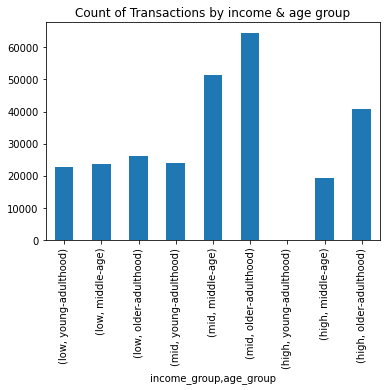

In [56]:
count_vals = df_all.groupby(['income_group','age_group']).size()

(count_vals[:10]).plot(kind="bar");
plt.title("Count of Transactions by income & age group");

#### Older Adulthood age group (56 and above) account for most of the high income group
#### Let's focus on 'older-adulthood' age group and 'high' income group

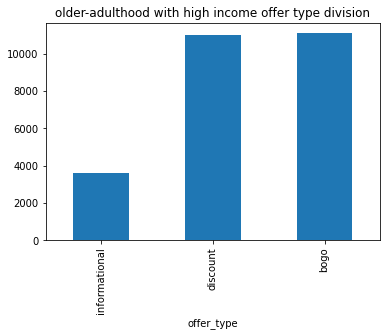

In [57]:
count_vals = df_all[(df_all['age_group'] == 'older-adulthood') & (df_all['income_group'] == 'high')].groupby('offer_type').size().sort_values()

(count_vals[:10]).plot(kind="bar");
plt.title("older-adulthood with high income offer type division");

### Bogo and Discount offer types are well recieved

### Lets see which channels older and high income people use

In [58]:
df_all[(df_all['age_group'] == 'older-adulthood') & 
       (df_all['income_group'] == 'high')].groupby(['offer_id','offer_type']).sum()[['channel_email','channel_mobile','channel_social','channel_web']]

,,channel_email,channel_mobile,channel_social,channel_web
offer_id,offer_type,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,2402,0,0,2402
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3054,3054,3054,3054
2906b810c7d4411798c6938adc9daaa5,discount,2525,2525,0,2525
3f207df678b143eea3cee63160fa8bed,informational,1662,1662,0,1662
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,2786,2786,2786,2786
5a8bc65990b245e5a138643cd4eb9837,informational,1940,1940,1940,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,2486,2486,0,2486
ae264e3637204a6fb9bb56bc8210ddfd,bogo,2868,2868,2868,0
f19421c1d4aa40978ebb69ca19b0e20d,bogo,2963,2963,2963,2963


#### All channels are well used

Descriptive Analytics Conclusion

#### "Create more Discount and Bogo offer types to Older Adult population (56 and above) with high income (78000 and above) and distribute them on all the channels"

## Predictive Analytics

When offer_id = N/A we have all transactions, and when offer_id != N/A we have all offers

To work with prediction we first need to change categorical variables to numerical

In [59]:
#Here we take a subset of the dataset with all offers, and we drop null values
df_all_offers = df_all[df_all['offer_id'] != 'N/A']
df_all_offers = df_all_offers.drop(['amount','age','income','became_member_on',],axis=1)

In [60]:
df_all_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   person              167581 non-null  object  
 1   event               167581 non-null  object  
 2   offer_id            167581 non-null  object  
 3   difficulty          167581 non-null  Int64   
 4   duration            167581 non-null  Int64   
 5   offer_type          167581 non-null  object  
 6   reward              167581 non-null  Int64   
 7   channel_email       167581 non-null  Int64   
 8   channel_mobile      167581 non-null  Int64   
 9   channel_social      167581 non-null  Int64   
 10  channel_web         167581 non-null  Int64   
 11  time                167581 non-null  Int64   
 12  age_group           148805 non-null  category
 13  gender              148805 non-null  object  
 14  income_group        148805 non-null  category
 15  member_since_year

In [61]:
df_all_offers.head(5)

,person,event,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,time,age_group,gender,income_group,member_since_year,member_since_month,member_duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1,0,older-adulthood,F,high,2017,5,1715
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1,0,NaN,None,NaN,2017,8,1628
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,1,0,older-adulthood,M,mid,2018,4,1363
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1,0,NaN,None,NaN,2017,9,1576
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1,0,NaN,None,NaN,2017,10,1569


In [62]:
categories = ['offer_type', 'age_group', 'gender','income_group']
ids = ['offer_id','person']
numericals = ['difficulty', 'duration', 'reward', 'time','member_duration']


#Change Categories to Values
for category in categories:
    dummies = pd.get_dummies(df_all_offers[category])
    df_all_offers = pd.concat([df_all_offers,dummies], axis = 1)
    df_all_offers = df_all_offers.drop(category, axis=1)
        
    
#change offer_id and person to numbers.
for idx in ids:
    unique_id = df_all_offers[idx].unique().tolist()
    map_id = dict(zip(unique_id,range(len(unique_id))))
    df_all_offers.replace({idx:map_id},inplace=True)

# using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler() 
df_all_offers[numericals] = scaler.fit_transform(df_all_offers[numericals])

#target variable from string to numeric values
df_all_offers['event'] = df_all_offers['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})

df_all_offers.head(5)

,person,event,offer_id,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,...,informational,young-adulthood,middle-age,older-adulthood,F,M,O,low,mid,high
0,0,1,0,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,1,1,0,0,0,0,1
1,1,1,1,1.00,1.000000,0.5,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1,2,0.50,0.571429,0.2,1,1,0,1,...,0,0,0,1,0,1,0,0,1,0
3,3,1,3,0.50,1.000000,0.2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,1,4,0.50,0.285714,1.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
data=df_all_offers.drop('event',axis=1);
label=df_all_offers['event']

In [64]:
#Test and Training set creation
X_train, X_test, y_train, y_test = train_test_split(data,label ,test_size= 0.2 ,random_state=13 )
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 134064 rows
Testing set: 33517 rows


In [65]:
# Function for training a model : reuseable
def model_training(model):
    """
    input:
    model used
    output:
    F1 Score, Model Name
           
    """
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    F1_Score = fbeta_score(y_test, predict ,beta = 0.5 ,average='micro')*100
    model_name = model.__class__.__name__
    
    return F1_Score, model_name

In [66]:
clf_1 = RandomForestClassifier(random_state = 13)
clf_1_f1, clf_1_model_name = model_training(clf_1)

In [67]:
clf_2 = DecisionTreeClassifier(random_state = 13)
clf_2_f2, clf_2_model_name = model_training(clf_2)

In [68]:
models = {'Model': [clf_1_model_name, clf_2_model_name], 
          'F1 score':[clf_1_f1, clf_2_f2]}
          
result = pd.DataFrame(models)
result

,Model,F1 score
0,RandomForestClassifier,38.839992
1,DecisionTreeClassifier,63.525972


## We get quite bad accuracy here

### Lets try using correlation based feature selection to select only important features

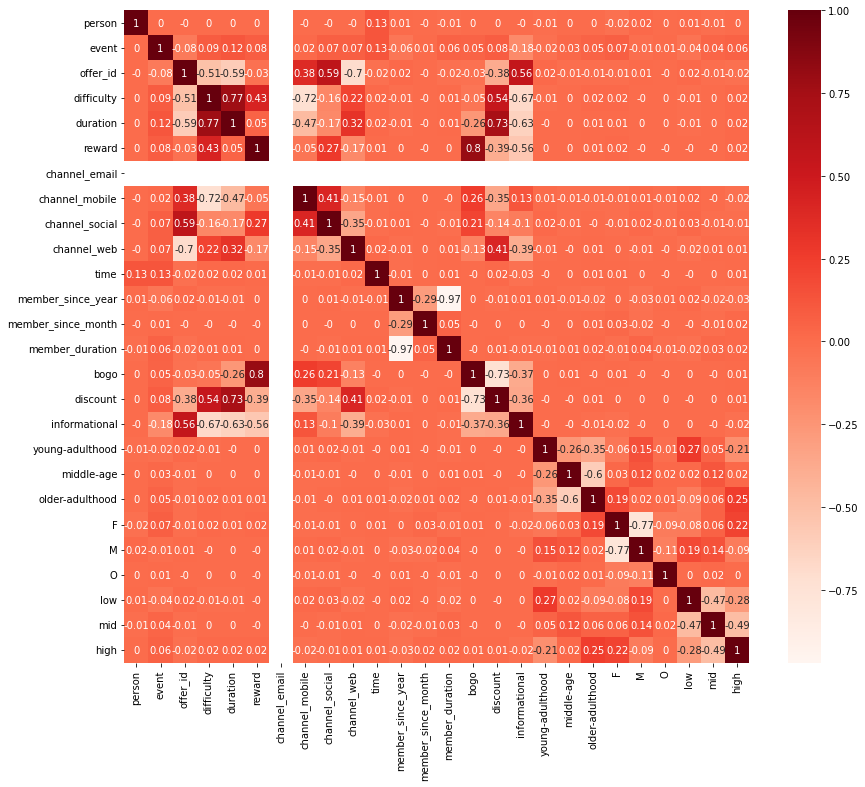

In [86]:
#Using Pearson Correlation
plt.figure(figsize=(14,12))
cor = df_all_offers.corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [70]:
#Correlation with output variable
cor_target = abs(cor["event"])
#Selecting least correlated features
relevant_features = cor_target[cor_target>0.08]
relevant_features

event            1.000000
offer_id         0.081448
difficulty       0.090037
duration         0.117016
time             0.125471
discount         0.081513
informational    0.184113
Name: event, dtype: float64

In [71]:
df_all_offers_corealted = df_all_offers[relevant_features.index.values]

In [72]:
df_all_offers_corealted.head(2)

,event,offer_id,difficulty,duration,time,discount,informational
0,1,0,0.25,0.571429,0.0,0,0
1,1,1,1.00,1.000000,0.0,1,0


In [73]:
data=df_all_offers_corealted.drop('event',axis=1);
label=df_all_offers_corealted['event']

In [74]:
#Splitting Training and test
X_train, X_test, y_train, y_test = train_test_split(data,label ,test_size= 0.2 ,random_state=13 )
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 134064 rows
Testing set: 33517 rows


In [75]:
clf_1 = RandomForestClassifier(random_state = 13)
clf_1_f1, clf_1_model_name = model_training(clf_1)

In [76]:
clf_2 = DecisionTreeClassifier(random_state = 13)
clf_2_f2, clf_2_model_name = model_training(clf_2)

In [77]:
models = {'Model': [clf_1_model_name, clf_2_model_name], 
          'F1 score':[clf_1_f1, clf_2_f2]}
          
result = pd.DataFrame(models)
result

,Model,F1 score
0,RandomForestClassifier,76.009189
1,DecisionTreeClassifier,75.877913


We see that accuracy here has significatly improved by using coorelation based feature selection

### Conclusion from Descriptive and Predictive Analytics

Descriptive : "Create more Discount and Bogo offer types to Older Adult population (56 and above) 
    with high income (78000 and above) and distribute them on all the channels"
    
Predictive : We can say with 76% accuracy if a customer would respond to an offer